# Fragmentation spectra embedding

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

from ms2lda_feature_extraction import LoadMSP, LoadGNPS, LoadMGF, LoadGNPSSeperateCollisions
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKeras
import numpy as np

from functions import *

Using TensorFlow backend.


In [3]:
if is_notebook():
    # import mpld3    
    %matplotlib inline
    # mpld3.enable_notebook()

In [4]:
input_dir = '../data/fingerid-104-traindata/spectra_gnps_massbank'
input_set = glob.glob(input_dir + '/*.ms')
l = LoadGNPS()
# l = LoadGNPSSeperateCollisions()
ms1, ms2, metadata = l.load_spectra(input_set)

Processed 100 spectra
Processed 200 spectra
Processed 300 spectra
Processed 400 spectra
Processed 500 spectra
Processed 600 spectra
Processed 700 spectra
Processed 800 spectra
Processed 900 spectra
Processed 1000 spectra
Processed 1100 spectra
Processed 1200 spectra
Processed 1300 spectra
Processed 1400 spectra
Processed 1500 spectra
Processed 1600 spectra
Processed 1700 spectra
Processed 1800 spectra
Processed 1900 spectra
Processed 2000 spectra
Processed 2100 spectra
Processed 2200 spectra
Processed 2300 spectra
Processed 2400 spectra
Processed 2500 spectra
Processed 2600 spectra
Processed 2700 spectra
Processed 2800 spectra
Processed 2900 spectra
Processed 3000 spectra
Processed 3100 spectra
Processed 3200 spectra
Processed 3300 spectra
Processed 3400 spectra
Processed 3500 spectra
Processed 3600 spectra
Processed 3700 spectra
Processed 3800 spectra
Processed 3900 spectra
Processed 4000 spectra
Processed 4100 spectra
Processed 4200 spectra
Processed 4300 spectra
Processed 4400 spect

In [5]:
def make_spec_matrix(ms1, ms2, min_frag_mz=20, max_frag_mz=500, normalise=1000.0):
    doc_index = {}
    n_docs = len(ms1)
    i = 0
    for m in ms1:
        doc_index[m.name] = i
        i += 1
    n_words = max_frag_mz - min_frag_mz + 1
    n_docs = len(doc_index)
    doc_matrix = np.zeros((n_docs,n_words),np.double)
    for m in ms2:
        mz = m[0]
        mz_int = (int)(np.round(mz))
        doc_pos = doc_index[m[3].name]
        if mz_int <= max_frag_mz and mz_int >= min_frag_mz:
            mz_pos = mz_int - min_frag_mz
            doc_matrix[doc_pos,mz_pos] += m[2]
            
    s = doc_matrix.sum(axis=1)
    toremove = []
    for doc,doc_pos in doc_index.items():
        if s[doc_pos] == 0:
            toremove.append(doc)
    
    for doc in toremove:
        doc_pos = doc_index[doc]
        doc_matrix = np.delete(doc_matrix,(doc_pos),axis=0)
        del doc_index[doc]
        for d,p in doc_index.items():
            if p > doc_pos:
                doc_index[d] -= 1
    
    if normalise > 0:
        s = doc_matrix.max(axis=1)
        s = s[:,None]
        doc_matrix *= (normalise/s)

    return doc_index, doc_matrix

In [6]:
min_frag_mz = 20
max_frag_mz = 900
normalise = 1.0
doc_index, doc_matrix = make_spec_matrix(ms1, ms2, min_frag_mz, max_frag_mz, normalise)

In [7]:
data = {
    'vocab': np.arange(min_frag_mz, max_frag_mz+1),
    'spectra': doc_matrix,
    'doc_index': doc_index,
    'metadata': metadata
}

In [8]:
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
                        verbose=1, epsilon=1e-5)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
callbacks = [rlr, early_stop]
if is_notebook():
    callbacks.append(PlotLossesKeras())

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [9]:
original_dim = data['spectra'].shape[1]
latent_dim = 100
batch_size = 32
epochs = 200

In [10]:
autoencoder, encoder, decoder = get_simple_model(original_dim, original_dim, latent_dim)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 881)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               88200     
_________________________________________________________________
dense_2 (Dense)              (None, 881)               88981     
Total params: 177,181
Trainable params: 177,181
Non-trainable params: 0
_________________________________________________________________


In [11]:
pos = int(len(data['spectra']) * 0.8)
spectra_train = data['spectra'][0:pos, :]
spectra_test = data['spectra'][pos:, :]

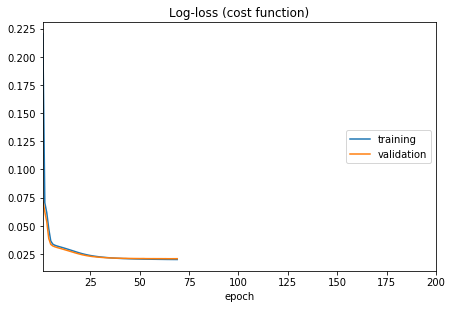

Epoch 00069: early stopping


In [12]:
autoencoder.fit(spectra_train, spectra_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(spectra_test, spectra_test),
                callbacks=callbacks)

[ 46  48  50  51  53  55  57  58  59  60  65  67  68  69  70  71  72  74
  77  78  80  83  85  87  90  91  93  94  96  97  98  99 101 102 103 104
 106 107 108 109 110 111 114 115 117 118 119 121 123 124 125 126 127 128
 131 132 135 137 138 139 143 145 146 147 150 151 152 153 154 155 159 161
 162 163 165 166 167 168 169 170 171 172 174 175 178 179 180 181 182 183
 184 185 186 188 189 192 197 202 204 206 209 210 211 212 225 226 228 229
 233 242 243 244 246 247 252 253 254 255 266 270 271 272 273 274 287 288
 289 292 309 310 317 333 334 335 336 337 338 339 340 343 346 347 349 350
 351 352 353 354 355 356 357 358 366 370 374 378 379 380 381 394 395 396
 428 432 439 453 458 491 492 493 587 631]


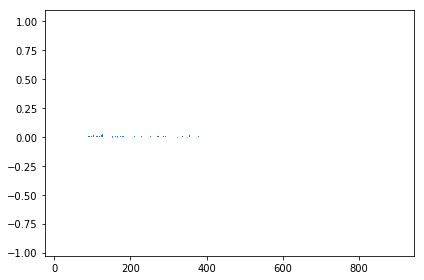

[ 39  40  41  42  43  44  45  47  51  55  56  57  60  61  63  64  65  67
  68  69  70  71  73  74  75  77  79  81  82  83  84  85  87  88  91  92
  93  97  98 101 102 103 105 106 107 109 110 111 115 116 117 119 124 127
 128 129 130 132 144 147]


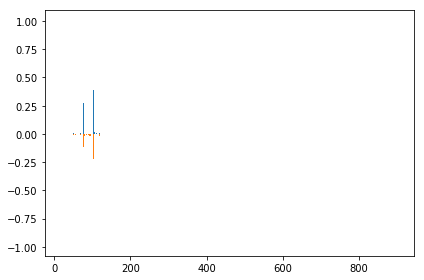

[103 105 115 117 121 133 147 148 149 176 177]


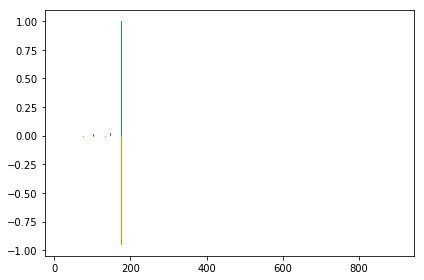

[115 116 117 120 143 155 165 171 179 193 199 208 221 235 236 315]


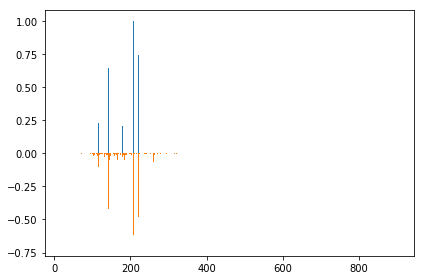

[ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 284 285 286 287 289 290 291 292 29

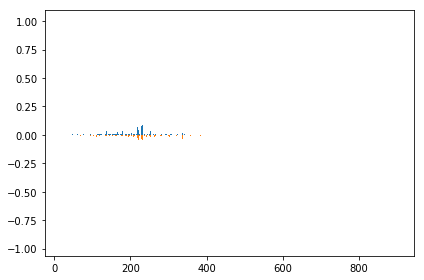

In [13]:
if is_notebook():
    spectra_encoded = encoder.predict(spectra_test)
    spectra_decoded = -1 * decoder.predict(spectra_encoded)
    for idx in range(5):
        pos = np.nonzero(spectra_test[idx])
        print(data['vocab'][pos])
        plt.bar(data['vocab'], spectra_test[idx])
        plt.bar(data['vocab'], spectra_decoded[idx])
        plt.tight_layout()
        plt.show()

In [14]:
label = 'gnps_massbank'

In [15]:
autoencoder.save('../models/spectra_autoencoder_%s.h5' % label)
encoder.save('../models/spectra_encoder_%s.h5' % label)
decoder.save('../models/spectra_decoder_%s.h5' % label)

In [16]:
doc_smiles = [metadata[doc_name]['smiles'] for doc_name in list(data['doc_index'].keys())]
data['smiles'] = np.array(doc_smiles)

In [17]:
import pickle
with open('../data/gnps_massbank_data.p', 'wb') as f:
    pickle.dump(data, f)